# Xplainable methods on Cyber Security Dataset

In this notebook we present several Xplainable methods that are used in nowdays AI projects. Our aim is to get deeper understanding on these methods, therefore, we apply them on datasets that are publicly available.

## CyberSecurity Dataset:

#### **Dataset Description**

This dataset consists of JSON files, each representing a directed graph (or **Digraph**) corresponding to a sequence of x86 assembly instructions. Each graph is annotated with a set of behaviors to be predicted—453 labels in total—corresponding to potentially malicious actions (e.g., `thinstall`, `clipboard`, `anti-debugging`, etc.). The full corpus contains 23,102 files.

The dataset was proposed as part of the **Sorbonne 2025 Data Challenge**, organized in collaboration with the **French Ministry of the Interior’s Command in Cyberspace (COMCYBER-MI)**.

#### **Approaches**

Two types of approaches can be considered to exploit these graphs:

- **Structural approach (graph-based)**: extraction of topological metrics (number of nodes, cycles, transitions, etc.), which can be used in models such as **Graph Neural Networks (GNNs)**.
- **Lexical approach (text-based)**: treating the assembly instructions as a sequence of words, enabling the use of classic techniques such as **TF-IDF**, **n-grams**, or pretrained language models like **CodeBERT** or **GraphCodeBERT**.

During the challenge, we experimented with both methods. Ultimately, the enriched lexical approach proved to be more effective.

#### **Data Processing**

For each JSON file, the assembly instructions (e.g., `CALL`, `JMP`) are extracted line by line. The nodes of the graph represent these instructions, while the edges indicate transitions between them. We extracted several types of features:

- **Structural**: number of nodes, edges, loops, etc.  
- **Specific**: frequency of certain instructions like `JMP`, `JCC`, etc.  
- **Global**: file size, graph complexity.

Additionally, we enriched the data by applying the **TF-IDF** method to the assembly keywords extracted from the graphs. After dimensionality reduction based on frequency, we retained a set of 250 significant instructions/mnemonics (see Appendix for method).

In total, each observation (JSON file) is described by **290 variables**, combining structural features and weighted lexical indicators.

#### **Target Behavior**

Although the dataset was initially designed to predict all **453 annotated behaviors**, our study focuses on a single target behavior: **_bypass Windows File Protection_**. This choice aims to focus the evaluation on the **explainability of classification models**, rather than on the complete multi-label detection problem.

## Model for the Cybersecurity Dataset

Based on the features extracted from the CFG (Control Flow Graph) files, several **classification models** were evaluated, including Logistic Regression, Multi-Layer Perceptrons (**MLP**), Random Forests, and Boosting models. After a hyperparameter optimization phase (which included, for example, the use of `class_weight='balanced'` to compensate for class imbalance), the best F1-score was achieved with the **HistGradientBoostingClassifier** model.

A separate **HistGradientBoosting** model was trained for each analyzed behavior, resulting in a total of **453 models**.

In this study, we focus on the behavior **_bypass Windows File Protection_**, meaning only one of the 453 models is examined in detail.

#### **Selected Model and Hyperparameters**

After optimization, the selected model has the following hyperparameters:

```python
HistGradientBoostingClassifier(
    class_weight='balanced',
    l2_regularization=0.5,
    learning_rate=0.25,
    max_depth=8,
    max_features=0.8,
    max_iter=400,
    max_leaf_nodes=53,
    min_samples_leaf=140,
    validation_fraction=None
)
```

This model achieved an **F1-score of 0.91**, which supports its use for explainability analysis in this specific case.
 
## Xplainable methods  
In this notebook, we will present the methods: 

- Global: 
  - Shap
  - PDP
  - ALE
  - LOFO

- Local:
  - Lime
  - ICE
  - Anchors
  - Shap 

### Import packages

In [10]:
### For Data treatment
import pandas as pd 
import numpy as np 
import pickle

### For Model training and Evaluation
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### For Visualisation
import matplotlib.pyplot as plt 
# import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Dataset - Sorbonne Data Challenge

In [11]:
X_train = pd.read_csv('../dataset_CyberSecurity/x_train.csv', index_col= 0)
X_test = pd.read_csv('../dataset_CyberSecurity/x_test.csv', index_col= 0)

y_train = pd.read_csv('../dataset_CyberSecurity/y_train.csv', index_col= 0)
y_test = pd.read_csv('../dataset_CyberSecurity/y_test.csv', index_col= 0)

model_to_test = "bypass Windows File Protection"
y_test = y_test[model_to_test]
y_train = y_train[model_to_test]

In [45]:
pd.read_csv('../dataset_CyberSecurity/y_test.csv', index_col= 0)

,64-bit execution via heavens gate,64bits,PEB access,accept command line arguments,access the Windows event log,act as TCP client,allocate RW memory,allocate RWX memory,allocate memory,allocate or change RW memory,...,winzip,wise,worm,write and execute a file,write clipboard data,write file on Linux,write file on Windows,write pipe,xorcrypt,yoda
22137,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
15278,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
22574,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8310,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22670,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16161,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4577,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model - Already trained and saved

In [12]:
filename = '../dataset_CyberSecurity/hgb.pkl'
with open(filename, 'rb') as file:
    model = pickle.load(file)

In [13]:
# y_pred = model.predict(X_test)

model_idx = 26 # bypass Windows File Protection
model_bypass_windws_file_protection = model.estimators_[model_idx]

negative_idx = 0
sample = X_train.iloc[negative_idx:negative_idx+1]

positive_idx = 21402
positive_sample = X_test.loc[positive_idx]

## **Explainable Methods**

## Explainable models

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

# Modèles à tester
tree_model = DecisionTreeClassifier(random_state=0)

tree_model.fit(X_train, y_train)

y_pred_tree = tree_model.predict(X_test)
f1 = f1_score(y_test, y_pred_tree)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.8649


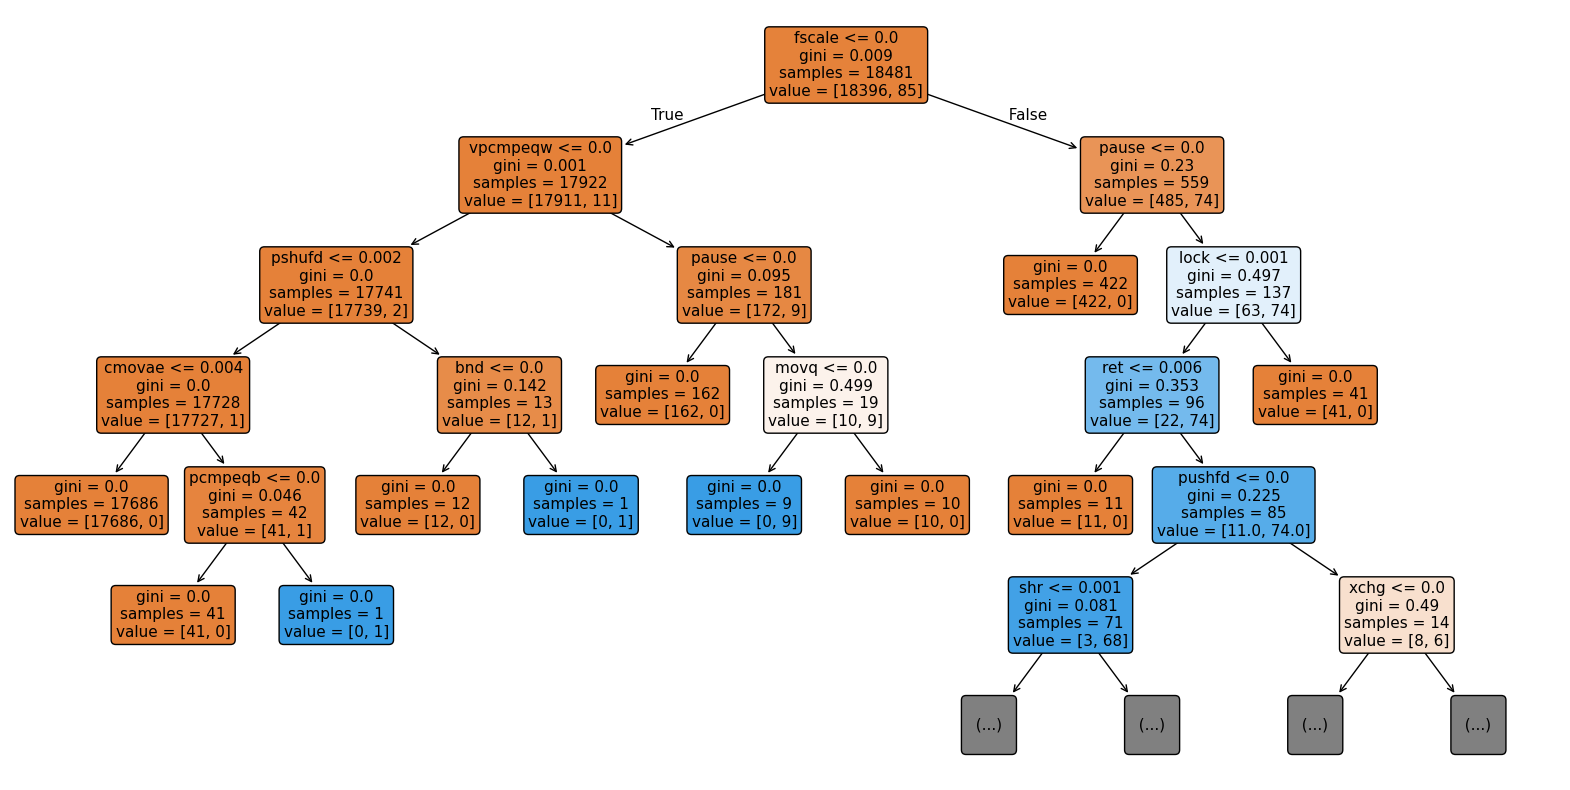

In [55]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=X_train.columns, filled=True, rounded=True, max_depth=5)
plt.show()

In [20]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

# Prédiction des classes sur le jeu de test
y_pred = ebm.predict(X_test)

# Calcul du F1-score 
score = f1_score(y_test, y_pred)
print(score)

0.9142857142857143


In [21]:
import matplotlib.pyplot as plt
from interpret import show

# Importance globale des features
ebm_global = ebm.explain_global()

show(ebm_global)

<!-- http://127.0.0.1:7546/2039974687088/ -->

In [27]:
ebm_local = ebm.explain_local(X_test, y_test)

show(ebm_local)

<!-- http://127.0.0.1:7546/2039933453952/ -->

### **Shap** - Global and Local

#### Global Shap

In [57]:
import shap

# Appliquer SHAP
explainer = shap.Explainer(model_bypass_windws_file_protection, X_test)
# shap_values_train = explainer.shap_values(X_train, check_additivity=False)
shap_values_test = explainer.shap_values(X_test, check_additivity=False)

 99%|===================| 4581/4621 [00:21<00:00]        

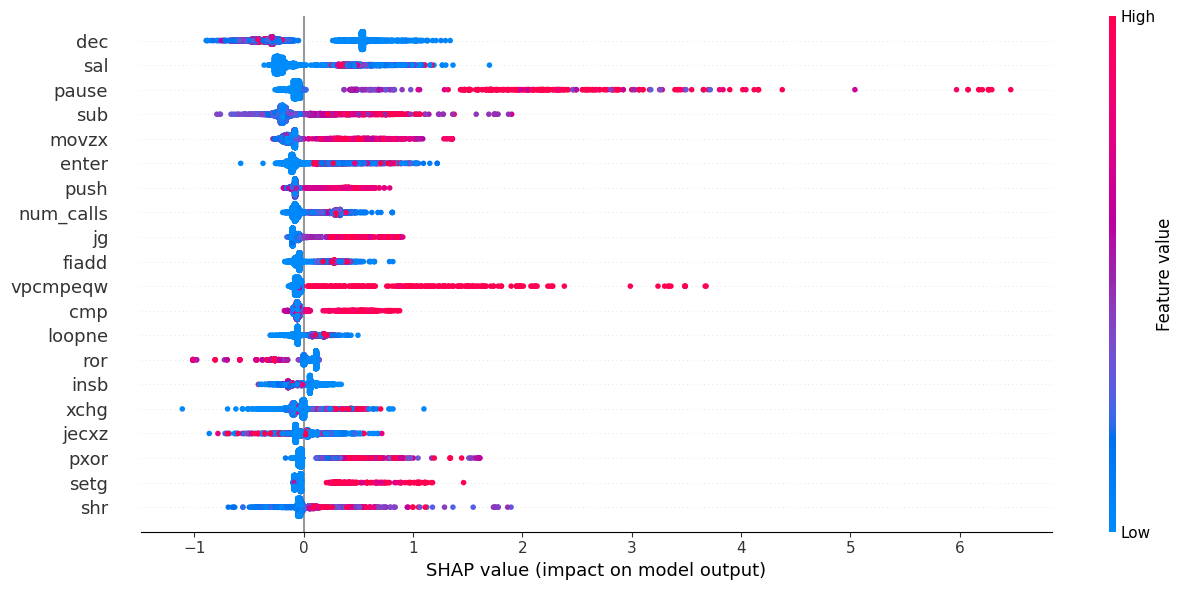

In [7]:
shap.summary_plot(shap_values_test, X_test, plot_size=(13,6))

In [65]:
if isinstance(shap_values_test, list):
    # Moyenne absolue sur les classes (shape: n_classes, n_samples, n_features)
    shap_values_mean = np.mean(np.abs(shap_values_test), axis=0)
else:
    shap_values_mean = np.abs(shap_values_test)

mean_abs_shap = shap_values_mean.mean(axis=0)
feature_importance = pd.Series(mean_abs_shap, index=X_test.columns)
top_features = feature_importance.sort_values(ascending=False).head(20)

print("Top features les plus influentes selon SHAP :")
print(top_features)

Top features les plus influentes selon SHAP :
dec          0.435075
sal          0.302531
pause        0.246203
sub          0.245382
movzx        0.201994
enter        0.161147
push         0.148194
num_calls    0.144487
jg           0.108603
fiadd        0.107783
vpcmpeqw     0.106506
cmp          0.103421
loopne       0.095674
ror          0.094323
insb         0.093284
xchg         0.092961
jecxz        0.088823
pxor         0.088676
setg         0.083605
shr          0.083335
dtype: float64


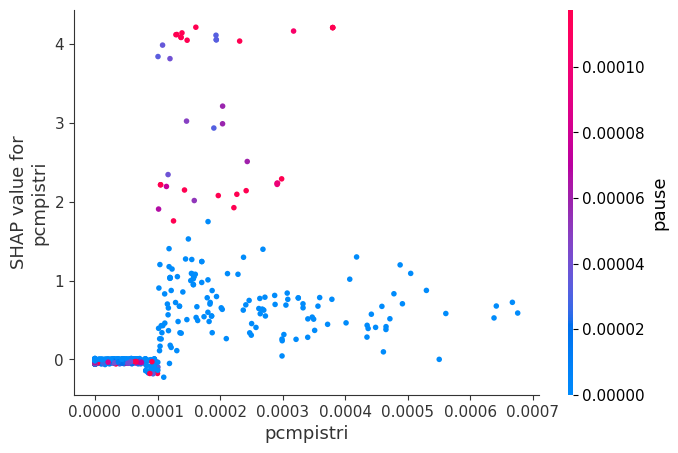

In [8]:
shap.dependence_plot("pcmpistri", shap_values_test, X_test)

## Local SHAP

In [ ]:
from saan_xai.shap import interactive_force_plot

interactive_force_plot(model_bypass_windws_file_protection, X_train)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Index:', max=18480), Output()),…

## Partial Dependency Plot

In [10]:
from saan_xai.pdp import plot_partial_dependence_interactive

plot_partial_dependence_interactive(
    pipeline=model_bypass_windws_file_protection,
    X_test=X_test,
    kind="average",
    grid_resolution=50,
    figsize=(7,4)
)

interactive(children=(Dropdown(description='Feature:', layout=Layout(width='300px'), options=('file_size', 'av…

Output()

Dans la figure precedente on présente le PDP plot pour la variable 'by pass windows File Protection'. Ce plot présente l'impacte de la valeur de cette variable sur la prédiction du modèle. Pour des faibles valeurs (plus petite que 0.008) l'impacte est faible parcontre l'impacte augmente pour les valeurs plus importantes.

## **ALE** - Global

In [11]:
from alibi.explainers import ALE, plot_ale

In [12]:
features = X_train.columns.tolist()
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

In [13]:
estimator_1 = model.estimators_[0]

# Alibi requires a callable that returns predictions
def predict_fn(X):
    return estimator_1.predict(X)

# Initialize ALE explainer
ale_explainer = ALE(predict_fn, feature_names=features, target_names= ['sub'])

# Fit ALE on the data
ale_exp = ale_explainer.explain(X_train_np)

KeyboardInterrupt: 

In [ ]:
# Configuration
feature_to_plot = 'sub'
label_names = ['bypass Windows File Protection']

# Get ALE data for the desired feature
feature_idx = X_test.columns.get_loc(feature_to_plot)
ale_feature = ale_exp.ale_values[feature_idx]
ale_grid = ale_exp.feature_values[feature_idx]

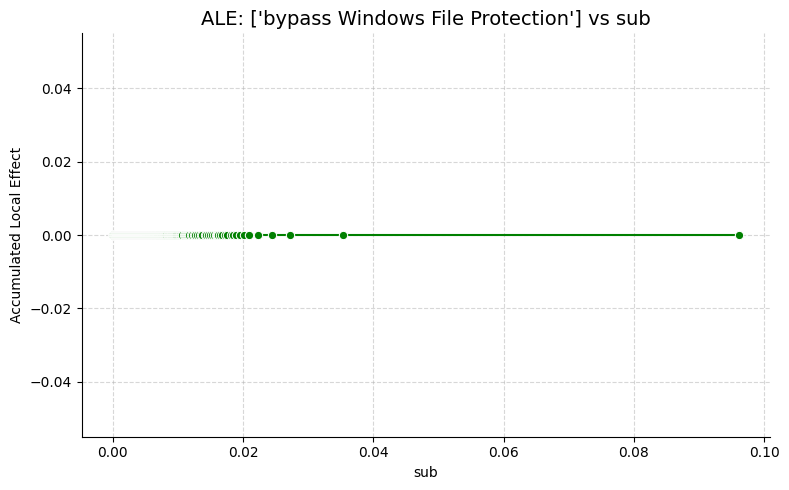

In [ ]:


# Optionally scale ALE values
scaler = MinMaxScaler()
ale_scaled = scaler.fit_transform(ale_feature.reshape(-1, 1)).flatten()

# Create DataFrame for plotting
df_ale = pd.DataFrame({
    feature_to_plot: ale_grid,
    'ALE': ale_scaled
})

# Plot ALE curve
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_ale, x=feature_to_plot, y='ALE', marker='o', color='green')
sns.despine()
plt.title(f"ALE: {label_names} vs {feature_to_plot}", fontsize=14)
plt.xlabel(feature_to_plot)
plt.ylabel("Accumulated Local Effect")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## **LOFO** - Global

La méthode **LOFO (Leave One Feature Out)** est une technique d’interprétabilité qui consiste à mesurer l’importance d’une variable en réentraînant le modèle sans cette variable, puis en comparant la performance du nouveau modèle avec celle du modèle d’origine. L’idée de base est simple : si une variable est vraiment utile, sa suppression devrait dégrader les performances du modèle. À l’inverse, si elle est peu informative, l’impact sera négligeable.

L’intuition derrière LOFO est la suivante : si la suppression d’une variable entraîne un changement significative des performances prédictives, cela indique que cette variable joue un rôle important dans les prédictions. Si les performances restent similaires, cela signifie que la variable n’apporte pas d’information précieuse. Dans certains cas, on peut même observer une amélioration des performances après la suppression d’une variable, ce qui indique une importance **négative** : la variable nuisait à la qualité du modèle, peut-être en introduisant du bruit ou de la redondance.

In [ ]:
model_lofo = model.estimators_[0]
model_lofo 

HistGradientBoostingClassifier(class_weight='balanced', l2_regularization=0.5,
                               learning_rate=0.25, max_depth=8,
                               max_features=0.8, max_iter=400,
                               max_leaf_nodes=53, min_samples_leaf=140,
                               validation_fraction=None)

In [ ]:
from lofo import LOFOImportance, Dataset, plot_importance

In [ ]:
feature_cols = X_train.columns.tolist()

df = X_train.copy()
df['bypass Windows File Protection'] = y_train['bypass Windows File Protection']

# Créer l’objet Dataset pour LOFO
dataset = Dataset(df=df, target= 'bypass Windows File Protection' , features=feature_cols)

In [ ]:
# Calculer l'importance LOFO
lofo = LOFOImportance(dataset, model=model_lofo, scoring="roc_auc", cv=4)

importance_df = lofo.get_importance()

100%|██████████| 290/290 [1:37:31<00:00, 20.18s/it]


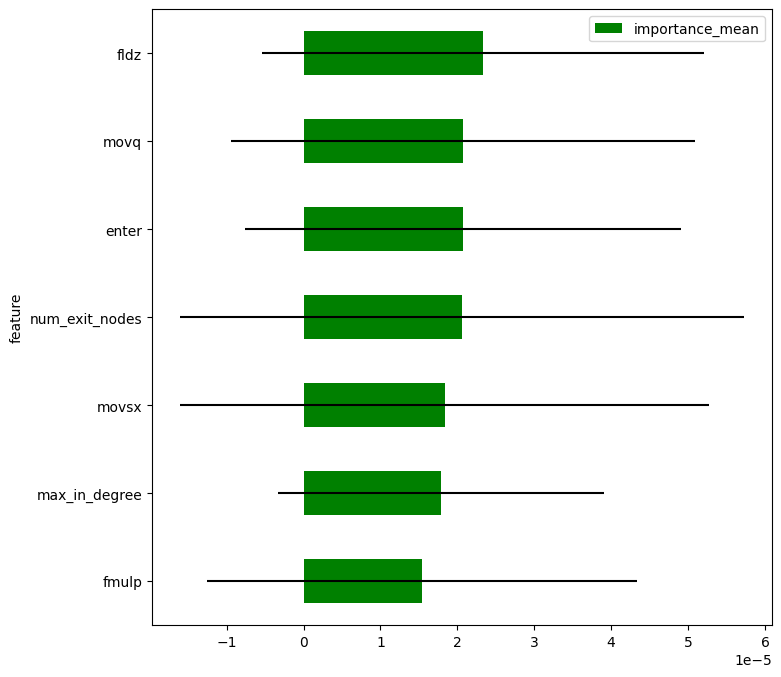

In [ ]:
%matplotlib inline
plot_importance(importance_df.iloc[:7])

# **Local Methods**

## **Lime** - Local

In [ ]:
from saan_xai.lime import interactive_lime_explanation

interactive_lime_explanation(model_bypass_windws_file_protection, X_test)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Index:', max=4620), Output()), …

## **ICE** - Local

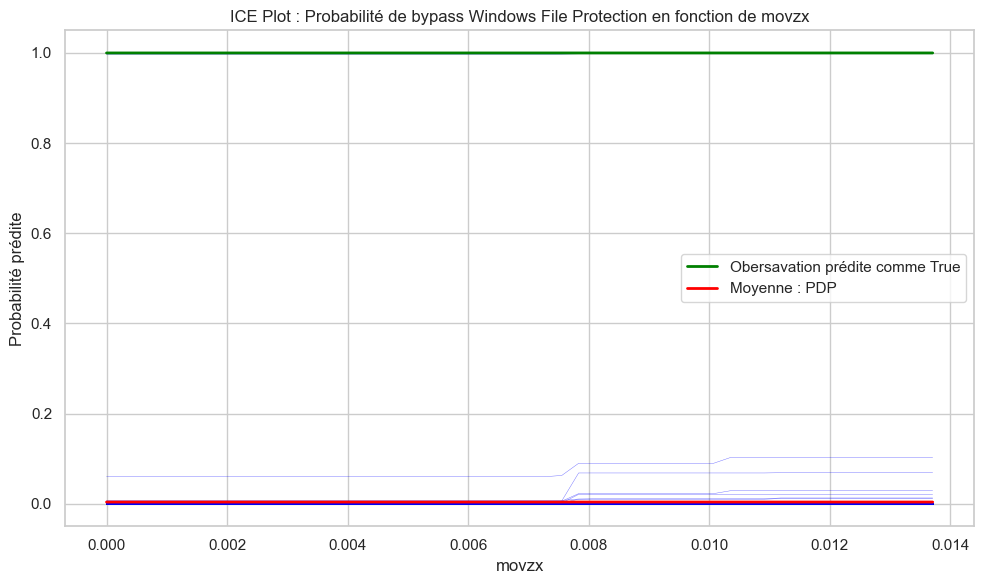

In [15]:
from sklearn.inspection import partial_dependence

feature_to_eval = "movzx"

# 1. Compute the partial dependence (ICE and average) manually
results = partial_dependence(model_bypass_windws_file_protection, X_test, features=[i for i, f in enumerate(X_test.columns) if f==feature_to_eval], kind="both", grid_resolution=50)

# Extract values
feature_vals = results['grid_values'][0]
ice_lines = results['individual'][0]   # shape (n_samples, n_grid_points)
average_line = results['average'][0]   # shape (n_grid_points,)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plot ICE lines
for i, row in enumerate(ice_lines):
    plt.plot(feature_vals, row, color='blue', alpha=0.6, linewidth=0.3)

plt.plot(feature_vals, ice_lines[200], color='green', linewidth=2, label="Obersavation prédite comme True")
plt.plot(feature_vals, average_line, color='red', label='Moyenne : PDP', linewidth=2)

plt.title(f"ICE Plot : Probabilité de bypass Windows File Protection en fonction de {feature_to_eval}")
plt.xlabel(feature_to_eval)
plt.ylabel("Probabilité prédite")
plt.legend()
plt.tight_layout()
plt.show()

## **Anchors** - Local

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, f1_score, precision_score


# Modèles à tester
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest_Classifier': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost_Classifier': XGBClassifier(n_estimators=100, random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
}

model_to_test = "bypass Windows File Protection"

# Entraînement et évaluation
trained_models = {}

q = top_features.index.to_list()

for name, model in models.items():
    if name != "HGB":
        model.fit(X_train[q], y_train)
    y_pred = model.predict(X_test[q])
    
    print(f"\n=== {name} ===")
    print(f"y_test positive values : {y_train[y_train==1].shape}")
    print(f"y_pred positive values : {y_pred[y_pred==1].shape}")
    print(f"Recall score: {(recall_score(y_test, y_pred)):.2f}")
    print(f"Precision score: {(precision_score(y_test, y_pred)):.2f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")
    
    trained_models[name] = model


=== LogisticRegression ===
y_test positive values : (85,)
y_pred positive values : (0,)
Recall score: 0.00
Precision score: 0.00
F1-Score: 0.00

=== RandomForest_Classifier ===
y_test positive values : (85,)
y_pred positive values : (18,)
Recall score: 0.94
Precision score: 0.89
F1-Score: 0.91

=== XGBoost_Classifier ===
y_test positive values : (85,)
y_pred positive values : (15,)
Recall score: 0.82
Precision score: 0.93
F1-Score: 0.88

=== DecisionTreeClassifier ===
y_test positive values : (85,)
y_pred positive values : (20,)
Recall score: 0.88
Precision score: 0.75
F1-Score: 0.81


In [71]:
# !uv pip install "numpy<2"
from alibi.explainers import AnchorTabular
rf_model_anc = trained_models['RandomForest_Classifier']

explainer = AnchorTabular(predictor=rf_model_anc.predict, feature_names=q)
explainer.fit(X_train[q].values)

# Sélection d'une instance à expliquer
idx = 200  # Choix d'une instance arbitraire
instance = X_test[q].iloc[idx].values

# Génération de l'explication avec Anchors
exp_anchor = explainer.explain(instance,
    threshold=0.85,
    delta=0.1,  # précision plus large
    tau=0.05,   # tolérance sur couverture
    batch_size=100,
    beam_size=1,
    min_samples_start=10000,
    max_anchor_size=8
)

# Affichage de la règle d'ancrage trouvée
print("\n Règle d'ancrage trouvée :")
print(exp_anchor.anchor)
print(f'prediction :{exp_anchor.data['raw']['prediction'][0]}')
print(f" Précision de la règle : {exp_anchor.precision:.2f}")
print(f" Couverture de la règle : {exp_anchor.coverage:.2f}")

Could not find an anchor satisfying the 0.85 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.



 Règle d'ancrage trouvée :
['vpcmpeqw > 0.00', 'movzx > 0.01', 'shr > 0.00', 'sub > 0.00', 'pause > 0.00', 'pxor > 0.00', 'cmp > 0.02', 'push > 0.03']
prediction :1
 Précision de la règle : 0.42
 Couverture de la règle : 0.00
